In [1]:
import os
import kagglehub
import pandas as pd
import xgboost as xgb
import shap

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

/Users/marek/miniconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Let us see some deep learning models and how they can be explained 
2. Your turn: 
    1. Train at least two advanced models on the energy dataset from TSA_Example notebook. You may choose to use only the last 5 years of the dataset to reduce data size 
    2. Explain the patterns the model has learned using SHAP local and global plots 
    3. Explain the patterns using LIME 
    4. Compare the answers from LIME & SHAP (global & some local) – what do you see? Is it the same?

In [2]:
# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)

Path to dataset files: /Users/marek/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3


In [3]:
dataset_path = "/Users/marek/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3"

files = os.listdir(dataset_path)
print(files)


['est_hourly.paruqet', 'PJMW_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv', 'DAYTON_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'FE_hourly.csv', 'DOM_hourly.csv', 'EKPC_hourly.csv', 'DEOK_hourly.csv', 'DUQ_hourly.csv', 'AEP_hourly.csv', 'COMED_hourly.csv']


In [4]:
file_path = "/Users/marek/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3/PJME_hourly.csv"

In [5]:
df = pd.read_csv(file_path)
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()



In [6]:
df5y = df[df.index >= '08-01-2013']

def create_features(df):
    """
    Create time series features and lag features based on time series index.
    """
    df = df.copy()

    # Basic time-based features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Lag features
    df['lag_1d'] = df['PJME_MW'].shift(1)   # 1 day lag
    df['lag_1w'] = df['PJME_MW'].shift(7)   # 1 week lag
    df['lag_1m'] = df['PJME_MW'].shift(30)  # 1 month lag (approx. 30 days)
    df['lag_1y'] = df['PJME_MW'].shift(365) # 1 year lag

    # Rolling statistics features
    df['rolling_mean_3d'] = df['PJME_MW'].rolling(window=3).mean()  # Last 3 days rolling mean
    df['rolling_mean_30d'] = df['PJME_MW'].rolling(window=30).mean()  # Last month rolling mean
    df['rolling_mean_same_month_last_year'] = df['PJME_MW'].shift(365).rolling(window=30).mean()  # Same month previous year rolling mean
    df['rolling_mean_same_week_last_year'] = df['PJME_MW'].shift(365).rolling(window=7).mean()  # Same week previous year rolling mean

    return df

df5y = create_features(df)

df5y

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1d,lag_1w,lag_1m,lag_1y,rolling_mean_3d,rolling_mean_30d,rolling_mean_same_month_last_year,rolling_mean_same_week_last_year
Datetime,,,,,,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,30393.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,29265.0,NaN,NaN,NaN,29338.333333,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,28357.0,NaN,NaN,NaN,28507.000000,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,27899.0,NaN,NaN,NaN,28104.333333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,45641.0,45372.0,45313.0,42771.0,45486.000000,41515.666667,38934.233333,38711.142857
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,44057.0,46534.0,46430.0,43742.0,44318.000000,41409.866667,38948.666667,40083.428571
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,43256.0,47154.0,47867.0,44607.0,42955.000000,41199.366667,38906.000000,41346.428571


In [7]:
FEATURES = [
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
    'lag_1d', 'lag_1w', 'lag_1m', 'lag_1y',
    'rolling_mean_3d', 'rolling_mean_30d', 'rolling_mean_same_month_last_year', 'rolling_mean_same_week_last_year'
]
TARGET = 'PJME_MW'

X = df5y[FEATURES]
y = df5y[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [8]:
import numpy as np

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Regression output layer
])

model.compile(optimizer='adam', loss='mse')
X_train_np = np.array(X_train, dtype=np.float32)
y_train_np = np.array(y_train, dtype=np.float32)
X_test_np = np.array(X_test, dtype=np.float32)
y_test_np = np.array(y_test, dtype=np.float32)
model.fit(X_train_np, y_train_np, epochs=50, batch_size=16, verbose=1, validation_data=(X_test_np, y_test_np))

Epoch 1/50
   1/7269 [..............................] - ETA: 17:43 - loss: nan

2025-03-11 18:34:05.217952: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7269/7269 [==============================] - 4s 464us/step - loss: nan - val_loss: nan
Epoch 2/50
7269/7269 [==============================] - 4s 491us/step - loss: nan - val_loss: nan
Epoch 3/50
7269/7269 [==============================] - 4s 501us/step - loss: nan - val_loss: nan
Epoch 4/50
7269/7269 [==============================] - 3s 461us/step - loss: nan - val_loss: nan
Epoch 5/50
7269/7269 [==============================] - 3s 440us/step - loss: nan - val_loss: nan
Epoch 6/50
7269/7269 [==============================] - 3s 473us/step - loss: nan - val_loss: nan
Epoch 7/50
7269/7269 [==============================] - 4s 532us/step - loss: nan - val_loss: nan
Epoch 8/50
7269/7269 [==============================] - 3s 462us/step - loss: nan - val_loss: nan
Epoch 9/50
7269/7269 [==============================] - 3s 445us/step - loss: nan - val_loss: nan
Epoch 10/50
7269/7269 [==============================] - 3s 480us/step - loss: nan - val_loss: nan
Epoch 11/50
7269/7269 [=======

 99%|===================| 28767/29074 [16:18<00:10]        

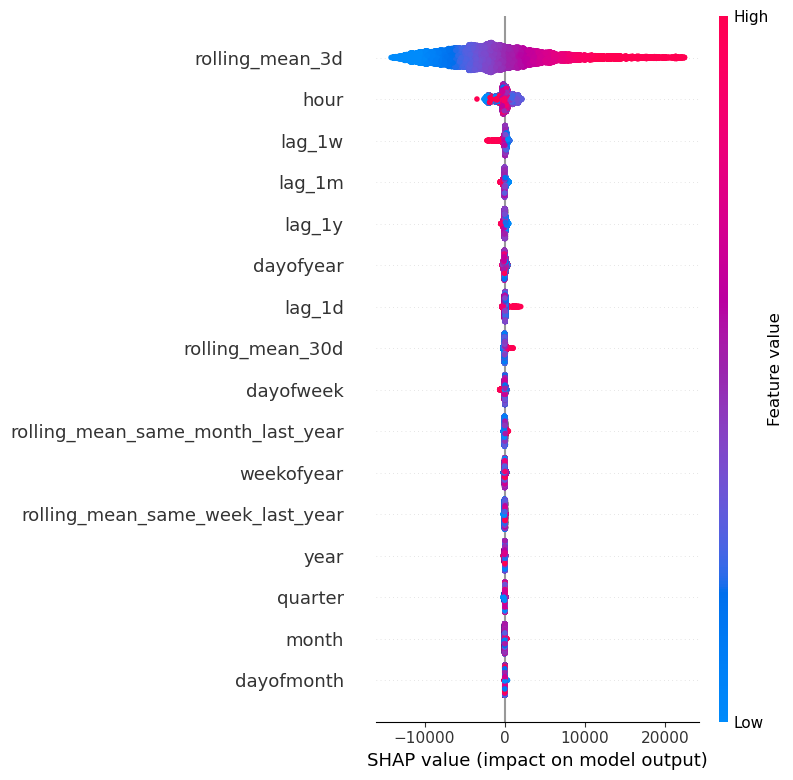

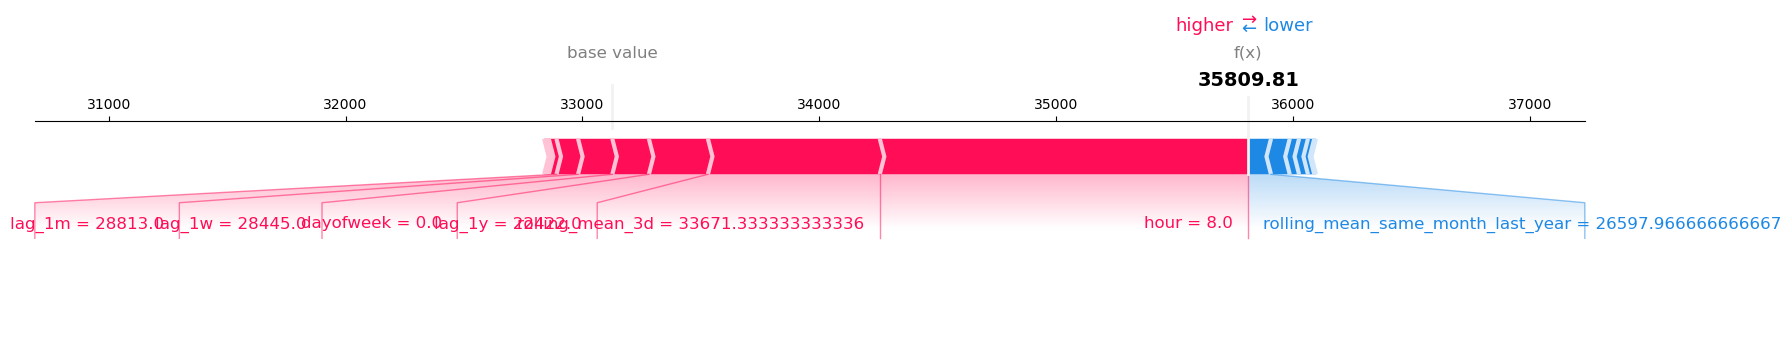

In [9]:
# SHAP explanation for XGBoost
explainer_xgb = shap.Explainer(xgb_model, X_train.astype(float))
shap_values_xgb = explainer_xgb(X_test)

# SHAP summary plot (Global explanation)
shap.summary_plot(shap_values_xgb, X_test)

# SHAP force plot for local explanation (first instance)
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0].values, X_test.iloc[0,:], matplotlib=True)


In [10]:
# SHAP explanation for Neural Network
explainer_nn = shap.Explainer(model, X_train)
shap_values_nn = explainer_nn(X_test)

# SHAP summary plot for Neural Network
shap.summary_plot(shap_values_nn, X_test)

# SHAP force plot for first instance (Neural Network)
shap.force_plot(explainer_nn.expected_value, shap_values_nn[0].values, X_test[0], matplotlib=True)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''